<a href="https://colab.research.google.com/github/fouad6225/projects/blob/main/3d_object_classification_with_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.8/677.8 KB 21.9 MB/s eta 0:00:00


In [4]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)


NameError: ignored

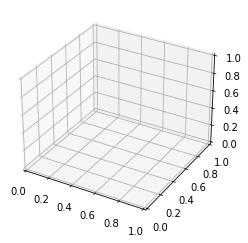

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


ax.plot_trisurf(trim.vertices[:, 0], trim.vertices[:,1], trim.vertices[:,2], triangles=trim.faces)

In [6]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")


473402300/473402300 [==============================] - 13s 0us/step


In [7]:
trim = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
trim.show()


/root/.keras/datasets/ModelNet10


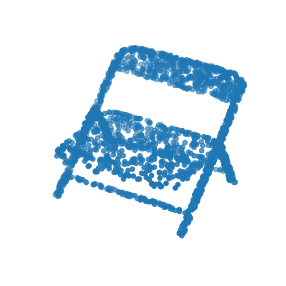

In [8]:
points = trim.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()


In [9]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)
        print(class_map)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )



In [10]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)


processing class: toilet
{0: 'toilet'}
processing class: monitor
{0: 'toilet', 1: 'monitor'}
processing class: table
{0: 'toilet', 1: 'monitor', 2: 'table'}
processing class: chair
{0: 'toilet', 1: 'monitor', 2: 'table', 3: 'chair'}
processing class: night_stand
{0: 'toilet', 1: 'monitor', 2: 'table', 3: 'chair', 4: 'night_stand'}
processing class: dresser
{0: 'toilet', 1: 'monitor', 2: 'table', 3: 'chair', 4: 'night_stand', 5: 'dresser'}
processing class: desk
{0: 'toilet', 1: 'monitor', 2: 'table', 3: 'chair', 4: 'night_stand', 5: 'dresser', 6: 'desk'}
processing class: bed
{0: 'toilet', 1: 'monitor', 2: 'table', 3: 'chair', 4: 'night_stand', 5: 'dresser', 6: 'desk', 7: 'bed'}
processing class: bathtub
{0: 'toilet', 1: 'monitor', 2: 'table', 3: 'chair', 4: 'night_stand', 5: 'dresser', 6: 'desk', 7: 'bed', 8: 'bathtub'}
processing class: sofa
{0: 'toilet', 1: 'monitor', 2: 'table', 3: 'chair', 4: 'night_stand', 5: 'dresser', 6: 'desk', 7: 'bed', 8: 'bathtub', 9: 'sofa'}


In [11]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)


In [12]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


In [13]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))


In [14]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])


In [15]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()


Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

In [16]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)
 

Epoch 1/20
125/125 [==============================] - 575s 4s/step - loss: 3.5627 - sparse_categorical_accuracy: 0.2759 - val_loss: 278256757715763200.0000 - val_sparse_categorical_accuracy: 0.3161
Epoch 2/20
125/125 [==============================] - 569s 5s/step - loss: 2.9464 - sparse_categorical_accuracy: 0.4034 - val_loss: 5.0590 - val_sparse_categorical_accuracy: 0.2170
Epoch 3/20
125/125 [==============================] - 564s 5s/step - loss: 2.7722 - sparse_categorical_accuracy: 0.4736 - val_loss: 112243867648.0000 - val_sparse_categorical_accuracy: 0.3722
Epoch 4/20
125/125 [==============================] - 558s 4s/step - loss: 2.6540 - sparse_categorical_accuracy: 0.5084 - val_loss: 4001833680896.0000 - val_sparse_categorical_accuracy: 0.4449
Epoch 5/20
125/125 [==============================] - 559s 4s/step - loss: 2.4628 - sparse_categorical_accuracy: 0.5725 - val_loss: 12265488121856.0000 - val_sparse_categorical_accuracy: 0.5573
Epoch 6/20
125/125 [======================

1/1 [==============================] - 0s 138ms/step


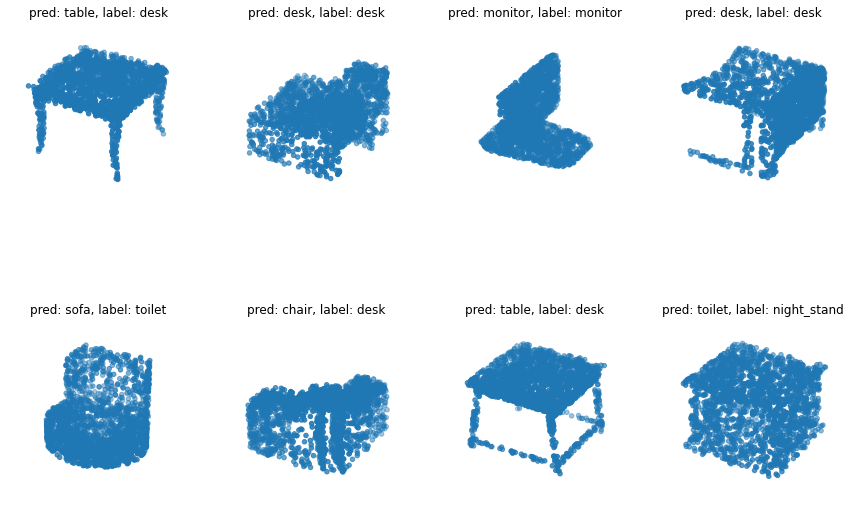

In [19]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()


In [ ]:
print(labels)

In [ ]:
print(preds
     )

In [ ]:
!pip install git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement git (from versions: none)
ERROR: No matching distribution found for git


Normalized confusion matrix


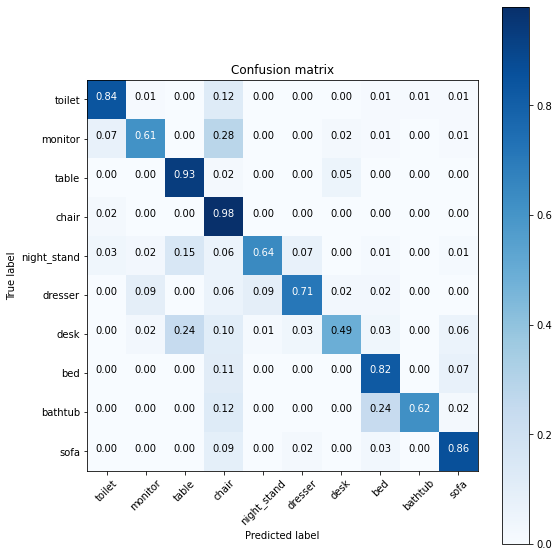

In [44]:

     
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(correct_labels,predicted_labels);
cm
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm,classes, normalize=True)

In [31]:
print(len(test_dataset))

29


NotImplementedError: ignored

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))
  
# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)


1/1 [==============================] - 0s 221ms/step


In [34]:
print(concatbatches)

tf.Tensor(
[[[-1.27709016e+01  2.45288299e+01  4.28100000e-01]
  [-1.12149842e+01  9.52982802e+00 -9.07190000e+00]
  [ 1.31552951e+01 -3.11872014e+01  8.09104392e+00]
  ...
  [-1.57500000e+01  3.46428960e+01 -5.32282408e-01]
  [ 3.05979240e+00 -4.66266819e+01  8.42810000e+00]
  [ 1.19791408e+01 -5.24223998e+00 -5.07190000e+00]]

 [[ 3.89287883e+00  7.98350000e+00  1.05558719e+00]
  [-4.46767806e+00 -7.95400000e+00  1.05629365e+01]
  [-2.33329446e+00 -8.01650000e+00  8.86072166e+00]
  ...
  [ 3.64204156e+00 -3.70198940e+00  7.81250000e+00]
  [ 4.73468209e+00  7.98350000e+00  4.87585525e+00]
  [ 5.95862057e+00  3.06870141e+00 -7.25000000e+00]]

 [[-7.21624289e+00 -8.42304268e+00  3.36245000e+00]
  [ 7.57279544e-01  1.28001980e+01  3.75932486e+00]
  [-8.64532329e+00 -9.72968070e+00 -3.57635000e+00]
  ...
  [ 1.09415000e+01 -3.59880214e+00  3.76736046e-01]
  [ 1.09415000e+01  1.14711034e+01  2.62863114e+00]
  [-9.86588349e+00  9.44027625e-01  7.99250000e-01]]

 ...

 [[-2.10559715e+01  2.2

In [43]:
classes=list(CLASS_MAP.values())

In [37]:
print(classes)

['toilet', 'monitor', 'table', 'chair', 'night_stand', 'dresser', 'desk', 'bed', 'bathtub', 'sofa']
